# Explore Project Features

In [2]:
suppressMessages(library(tidyverse))

my_db <- src_postgres("donorschoose")
projects_tbl <- tbl(my_db, "projects")
 

In [3]:
projects <- projects_tbl %>%
  filter(date_posted > "2015-01-01", date_posted < "2015-06-01")  %>% 
  collect()

In [4]:
str(projects)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	59404 obs. of  44 variables:
 $ _projectid                            : chr  "a506b44fbb5f9f9b09fe7f38de4d3412" "b42195e5694c5959a5beae9e81fb8272" "0093f207db1ec03d3da96d290bedd7ca" "b5b025aaa4d34a4a82f24810a556131b" ...
 $ _teacher_acctid                       : chr  "9d698d32e69ae906fc1c46a57fbf43b8" "ab8248c530a666d8db5d9b13ae71951d" "6969ae4a4c05e205388f15701aa8064f" "9434243cef1d5f28eaad100a046dbb6d" ...
 $ _schoolid                             : chr  "bdd0fa7a887ea7a396523afa77f06053" "858c3071b6a9ca5f5f717d20f64c8e3f" "40097873e37f11ece60cc17e02b4f55e" "d46ad4ad2e8bccf465baa55385930832" ...
 $ school_ncesid                         : chr  NA "270819002509" "120048000767" "370001102126" ...
 $ school_latitude                       : num  40.9 44.9 30.3 35 41.4 ...
 $ school_longitude                      : num  -73.8 -93.6 -81.8 -78.9 -72.9 ...
 $ school_city                           : chr  "New York City" "Chanhassen" "Jacksonville" "Fay

What's going on with the various prices? Including versus excluding optional support?

In [5]:
projects  %>% 
  select(total_donations, total_price_excluding_optional_support, total_price_including_optional_support)  %>% 
  transmute(
    support_rate = total_price_including_optional_support / total_price_excluding_optional_support
  )  %>% 
  summary()

  support_rate  
 Min.   :1.176  
 1st Qu.:1.176  
 Median :1.176  
 Mean   :1.176  
 3rd Qu.:1.176  
 Max.   :1.177  

The included optional support is about 17% of the project price.

In [6]:
projects  %>% 
  select(total_donations, total_price_excluding_optional_support, total_price_including_optional_support, funding_status)  %>% 
  filter(funding_status == "completed")  %>% 
  transmute(price_inc_diff = total_price_including_optional_support - total_donations)  %>% 
  summary()

 price_inc_diff    
 Min.   :-8403.77  
 1st Qu.:    0.00  
 Median :    0.01  
 Mean   :   15.45  
 3rd Qu.:   12.35  
 Max.   : 4667.59  

Warning message:
“Removed 1 rows containing missing values (geom_point).”

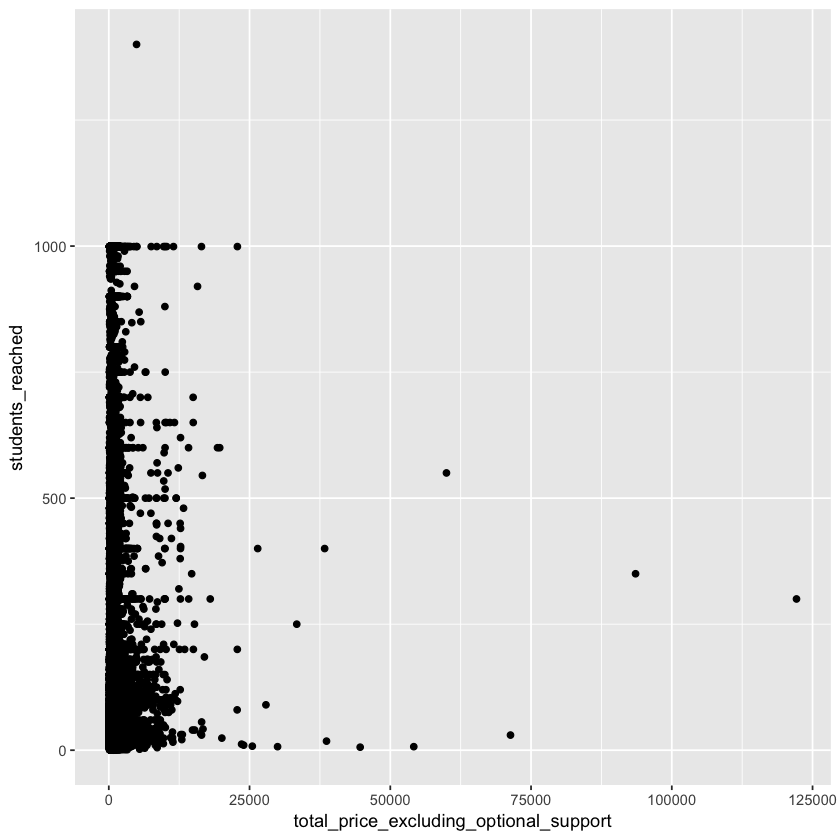

In [7]:
projects  %>% 
  ggplot(aes(total_price_excluding_optional_support, students_reached)) +
  geom_point()

Select out the columns that will be candidate features. Here I exclude any columns that are unknown at the time of posting (e.g., total donations), that contain redundant information (e.g., price including/excluding optional support), or that may be important predictors but could have unseen levels (e.g., teacher id).   Also drop any columns that have more than 5% missing values. 

Drop any  rows that still have any missing values.

Remove outlier prices greater than $20,000.

In [8]:
projects_trim <- projects  %>% 
  select(funding_status, school_zip, school_metro, school_charter, school_magnet, school_year_round, school_nlns, school_kipp, school_charter_ready_promise, teacher_prefix, teacher_teach_for_america, teacher_ny_teaching_fellow, primary_focus_subject, primary_focus_area, secondary_focus_subject, secondary_focus_area, resource_type, poverty_level, grade_level, vendor_shipping_charges, sales_tax, payment_processing_charges, total_price_excluding_optional_support, students_reached)  

prop_missing <- colMeans(is.na(projects_trim)) 
high_miss_cols <- prop_missing[prop_missing > 0.05]
projects_trim <- projects_trim[ , !(names(projects_trim) %in% high_miss_cols)]
projects_trim <- na.omit(projects_trim)
projects_trim <- projects_trim  %>% 
  filter(total_price_excluding_optional_support < 20000)  %>% 
  filter(funding_status %in% c("completed", "expired"))

In [9]:
dim(projects)

[1] 59404    44

In [10]:
dim(projects_trim)

[1] 36375    24

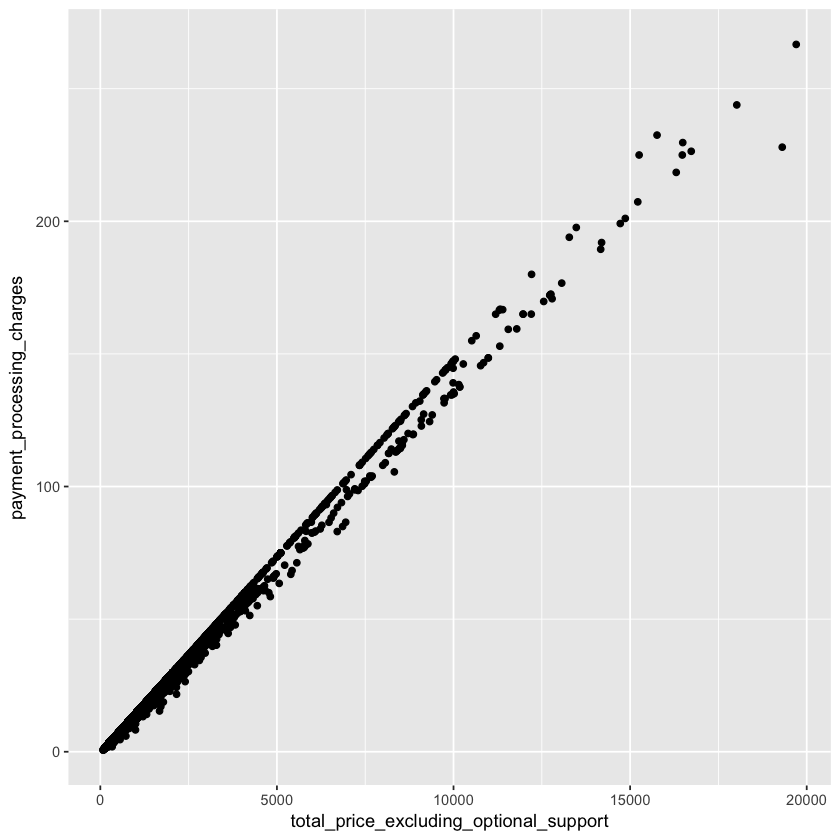

In [11]:
projects_trim  %>% 
  ggplot(aes(total_price_excluding_optional_support, payment_processing_charges)) +
  geom_point()

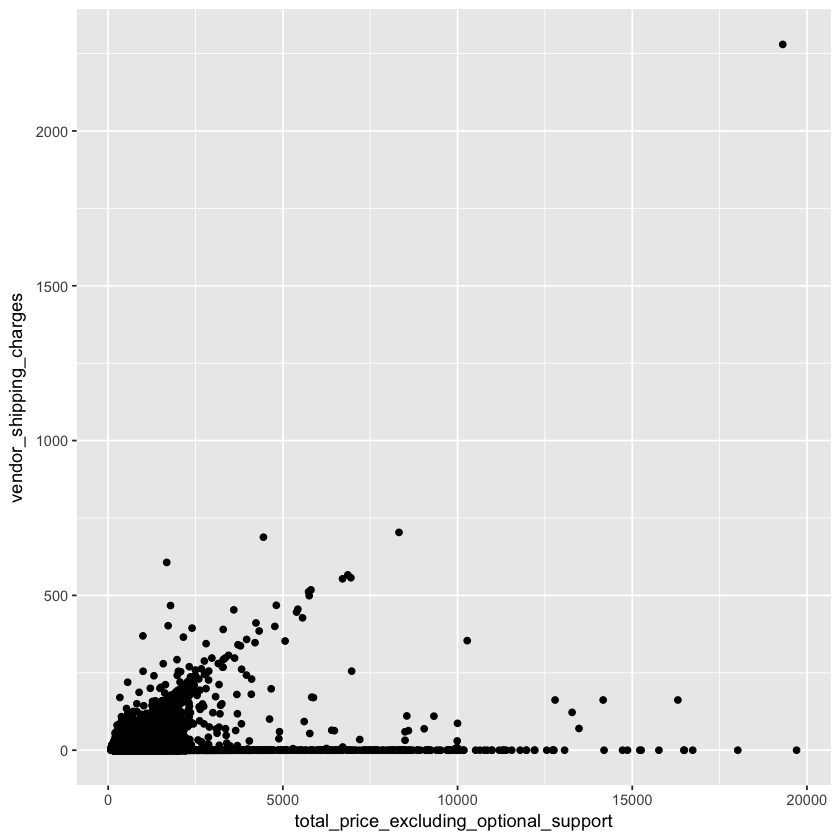

In [13]:
projects_trim  %>% 
  ggplot(aes(total_price_excluding_optional_support, vendor_shipping_charges)) +
  geom_point()

These above variables are all basically colinear with total price of project. Let's remove them from any modeling efforts.

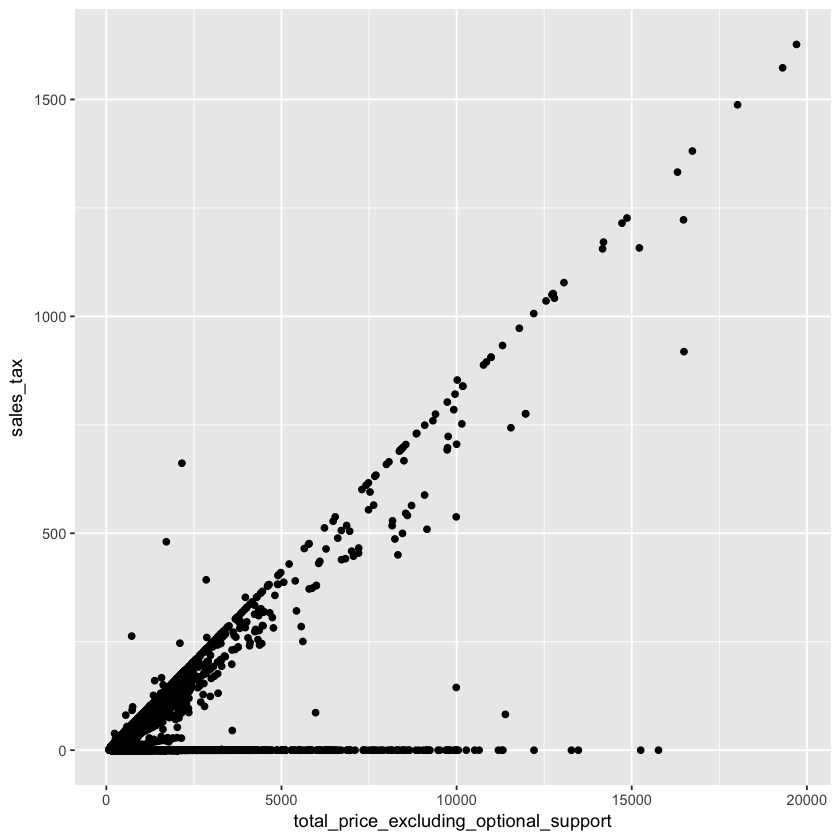

In [14]:
projects_trim  %>% 
  ggplot(aes(total_price_excluding_optional_support, sales_tax)) +
  geom_point()

## Feature Selection Notes

Initially there are 43 feature variables and 1 target.
I manually removed variables based on the following:
* unknown at the time of posting (e.g., total donations)
* very likely to take on new values unseen in previous test data (e.g., teacher account i)
* redundant (e.g. city/county/state, as well as subject/area)
* more than 5% missing (school metro, secondary subject/area)

This prunes the features down to 19.

I also removed rows with any missing values.

In [12]:
.libPaths()

[1] "/Users/mcbowers/anaconda/lib/R/library"